In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# remove pink warning boxes
import warnings
warnings.filterwarnings("ignore")

### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

#### Acquire

In [2]:
# acquire data

colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)





In [3]:
df_orig.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df_orig.shape

(13974, 7)

In [5]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

new.head()


,ip,timestamp,request_method,status,size,destination,request_agent
0,95.31.18.119,[21/Apr/2019:10:02:41+0000],GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
1,95.31.16.121,[17/Apr/2019:19:36:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2,97.105.15.120,[18/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0
3,97.105.19.58,[19/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,200,2056327,NaN,python-requests/2.21.0


In [6]:
new.shape

(4, 7)

In [7]:
# append new df to orig df

df = df_orig.append(new)

In [8]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [9]:
df.shape

(13978, 7)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Prepare 

To prepare df:

- clean timestamp by removing the brackets and trailing zeros
- replace the first colon in timestamp after year
- convert timestamp to datetime object
- set datetime index and sort
- remove page numbers from request_method
- convert bytes in size to megabytes as a new column
- drop the size column as size is a keyword and we will have the new size in mb column

In [11]:
def prep_data(df):
    
    # clean timestamp 
    df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
    # convert to datetime and replace colon with space
    df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
    # set datetime index and sort
    df = df.set_index('timestamp').sort_index()
    # for each col in list specified replace double quotes with single quotes
    for col in ['request_method', 'request_agent', 'destination']:
        df[col] = df[col].str.replace('"', '')
        # remove page numbers
        df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
    # create new col
    df['size_mb'] = [n/1024/1024 for n in df['size']]
    # drop size col
    df = df.drop(columns= 'size')
    return df

In [12]:
# call function to clean df
df = prep_data(df)

In [13]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [14]:
df.describe()

,status,size_mb
count,13978.000000,13978.000000
mean,200.356703,0.429155
std,10.182001,0.154010
min,200.000000,0.000000
25%,200.000000,0.477445
50%,200.000000,0.486506
75%,200.000000,0.487605
max,499.000000,1.961066


#### Finding anomalies in already existing data

- how many times a value of a variable (status) shows up?
- calculate probability for each status

In [15]:
# how many unique statuses we have in the dataset?
df.status.nunique()

3

In [16]:
# get the counts of ips in the dataset

status_df = pd.DataFrame(df.status.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'status', 'status': 'count'})

In [17]:
status_df

,status,count
0,200,13960
1,499,16
2,301,2


In [19]:
# calculate probabity for each status 

# status_prob = count for each status / total count in the dataframe

status_df2 = pd.DataFrame((df.status.value_counts(dropna=False))/df.status.count()).reset_index().\
                rename(columns={'index': 'status', 'status': 'status_proba'})
status_df2

,status,status_proba
0,200,0.998712
1,499,0.001145
2,301,0.000143


In [20]:
# merge the two data frames create above into a single one:
status_df = status_df.merge(status_df2)

status_df

,status,count,status_proba
0,200,13960,0.998712
1,499,16,0.001145
2,301,2,0.000143


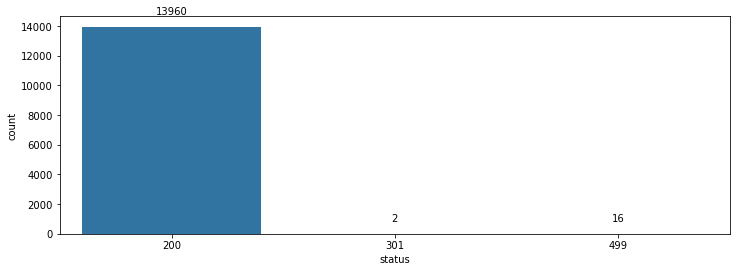

In [23]:
# plot the count for each status

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=status_df, x = 'status', y = 'count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 15), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='horizontal')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.¶

